In [ ]:
!pip install transformers
!pip install datasets
!pip install nltk
!pip install evaluate
!pip install seqeval
!git clone https://github.com/IndoNLP/nusa-crowd.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 13.6 MB/s 
     |████████████████████████████████| 163 kB 65.4 MB/s 
     |████████████████████████████████| 7.6 MB 52.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 13.2 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 115 kB 52.0 MB/s 
     |████████████████████████████████| 127 kB 53.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████|

In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Initialize library

In [ ]:
from datasets import load_dataset
import re

In [ ]:
import sys
sys.path.append("nusa-crowd")
path = "nusa-crowd/nusacrowd/nusa_datasets/id_stance"
dataset = load_dataset(path)

# see dataset sample:
df = dataset['train'].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

Dataset id_stance downloaded and prepared to /root/.cache/huggingface/datasets/id_stance/id_stance_source/1.0.0/fec4059be7d3c1008fc45ea9b0ed4d54d44d1cbc81024db3cee27e5d27710f62. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset["train"]

Dataset({
    features: ['person', 'event', 'title', 'content', 'stance_final'],
    num_rows: 337
})

In [ ]:
def sentence_tokenize(dataset):
  person = dataset["person"]
  event = dataset["event"]
  title = dataset["title"]
  stance = dataset["stance_final"]

  content = dataset["content"]
  
  # if the content length is zero, then the title held the content
  for i in range(len(content)):
    if len(content[i]) == 0:
      content[i] = title[i]
  # sent tokenize
  sent_tokenized_content = [nltk.tokenize.sent_tokenize(el) for el in content]

  result = {
      "person" : [],
      "event" : [],
      "title" : [],
      "content" : [],
      "stance" : []
  }

  for i in range(len(sent_tokenized_content)):
    for j in range(len(sent_tokenized_content[i])):
      result["person"].append(person[i])
      result["event"].append(event[i])
      result["title"].append(title[i])
      result["content"].append(sent_tokenized_content[i][j])
      result["stance"].append(stance[i])
  
  return result

In [ ]:
dataset["train"] = dataset["train"].map(
    sentence_tokenize,
    batched=True,
    remove_columns=dataset["train"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['person', 'event', 'title', 'content', 'stance'],
        num_rows: 12988
    })
})

In [ ]:
labels = {
    "O" : 0,
    "B-person" : 1,
    "I-person" : 2,
    "B-event" : 3,
    "I-event" : 4
}

In [ ]:
def create_bio_label(row,labels=labels):
  text = row["content"]
  tokenized_text = nltk.tokenize.word_tokenize(text)

  tokenized_person = nltk.tokenize.word_tokenize(row["person"])
  joined_person = ' '.join(tokenized_person)

  tokenized_event = nltk.tokenize.word_tokenize(row["event"])
  joined_event = ' '.join(tokenized_event)

  result_labels = {
      "person" : [],
      "event" : []
  }
  i = 0
  while i  < len(tokenized_text):
    window_person = tokenized_text[i:i+len(tokenized_person)]

    joined_window_person = ' '.join(window_person)
    if joined_window_person.lower() == joined_person.lower():
      added_labels = [labels["B-person"]] + [labels["I-person"]] * (len(window_person) - 1)
      result_labels["person"].extend(added_labels)
      i += len(window_person)
    else:
      result_labels["person"].append(labels["O"])
      i += 1
  
  i = 0
  while i  < len(tokenized_text):
    window_event = tokenized_text[i:i+len(tokenized_event)]

    joined_window_event = ' '.join(window_event)
    if joined_window_event.lower() == joined_event.lower():
      added_labels = [labels["B-event"]] + [labels["I-event"]] * (len(window_event) - 1)
      result_labels["event"].extend(added_labels)
      i += len(window_event)
    else:
      result_labels["event"].append(labels["O"])
      i += 1
  
  assert len(result_labels["person"]) == len(tokenized_text) == len(result_labels["event"])

  result_tags = []
  for i in range(len(tokenized_text)):
    new_token = result_labels["person"][i] + result_labels["event"][i]
    if new_token >= len(labels):
      # if overlapping then raise exception?
      raise Exception(f"No way : {text[:50]}")
    else:
      result_tags.append(new_token)
  return{ 'tokens' : tokenized_text, 'bio_tags' : result_tags}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['person', 'event', 'title', 'content', 'stance'],
        num_rows: 12988
    })
})

In [ ]:
dataset["train"]["person"][0]

'ahok'

In [ ]:
tokenized_dataset = dataset["train"].map(
    create_bio_label,
    remove_columns = dataset["train"].column_names
)

  0%|          | 0/12988 [00:00<?, ?ex/s]

In [ ]:
len_tokens = [len(tokens) for tokens in tokenized_dataset["tokens"]]

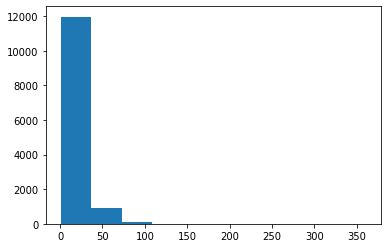

In [ ]:
import matplotlib.pyplot as plt

plt.hist(len_tokens)
plt.show()

In [ ]:
more_than_256 = []
for i,lt in enumerate(len_tokens):
  if lt > 256:
    more_than_256.append(i)

In [ ]:
more_than_256

[8565, 10627, 12339]

In [ ]:
tokenized_dataset = tokenized_dataset.select(
    (
        i for i in range(len(tokenized_dataset)) 
        if i not in set(more_than_256)
    )
)

In [ ]:
tokenized_dataset

Dataset({
    features: ['tokens', 'bio_tags'],
    num_rows: 12985
})

In [ ]:
import numpy as np
flatten_bio = [bio for el in tokenized_dataset["bio_tags"] for bio in el]
np.unique(flatten_bio,return_counts=True)

(array([0, 1, 2, 3, 4]), array([235082,   7284,    333,    186,    186]))

In [ ]:
def tokenize_and_align_labels(examples,tokenizer):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=256)

    labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenized_dataset = tokenized_dataset.map(lambda x : tokenize_and_align_labels(x,tokenizer), batched=True)

  0%|          | 0/13 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(labels))

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
flatten_bio_tags = [bio for el in tokenized_dataset["test"]["bio_tags"] for bio in el]

In [ ]:
import numpy as np

np.unique(flatten_bio_tags,return_counts=True)

(array([0, 1, 2, 3, 4]), array([46416,  1464,    60,    34,    34]))

In [ ]:
import evaluate
label_list = list(labels.keys())
metric = evaluate.load("seqeval")
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=2)

  # Remove ignored index (special tokens)
  true_predictions = [
      [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]

  results = metric.compute(predictions=true_predictions, references=true_labels)
  f1_person = results["person"]["f1"]
  f1_event = results["event"]["f1"]
  w_person = (1/results["person"]["number"]) / (1/results["person"]["number"] + 1/results["event"]["number"])
  w_event = (1/results["event"]["number"]) / (1/results["person"]["number"] + 1/results["event"]["number"])
  f1_weighted = f1_person * w_person + f1_event * w_event
  print(results)
  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": f1_weighted, # results["overall_f1"],
      "accuracy": results["overall_accuracy"],
  }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10388
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 13000
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text fol

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.020200,0.008231,0.930512,0.983311,0.823672,0.996730
2,0.009700,0.007384,0.950327,0.970628,0.884916,0.997313
3,0.007100,0.007294,0.965541,0.953939,0.662222,0.997167
4,0.002200,0.011976,0.954244,0.960614,0.647389,0.997438
5,0.002000,0.009165,0.962762,0.949266,0.726749,0.997021
6,0.001800,0.012137,0.955293,0.969960,0.757837,0.997521
7,0.001700,0.015878,0.946188,0.985981,0.896388,0.997605
8,0.000700,0.012510,0.962076,0.965287,0.905495,0.997438
9,0.000700,0.014708,0.950546,0.987984,0.920082,0.997834
10,0.000400,0.014199,0.957820,0.985314,0.908172,0.997980


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.7272727272727273, 'recall': 0.9411764705882353, 'f1': 0.8205128205128205, 'number': 34}, 'person': {'precision': 0.9363222871994802, 'recall': 0.9842896174863388, 'f1': 0.9597069597069597, 'number': 1464}, 'overall_precision': 0.930511686670878, 'overall_recall': 0.9833110814419226, 'overall_f1': 0.9561830574488802, 'overall_accuracy': 0.9967297117147143}


Saving model checkpoint to ./results/checkpoint-650
Configuration saved in ./results/checkpoint-650/config.json
Model weights saved in ./results/checkpoint-650/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-650/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-650/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.7906976744186046, 'recall': 1.0, 'f1': 0.8831168831168831, 'number': 34}, 'person': {'precision': 0.9549428379287155, 'recall': 0.9699453551912568, 'f1': 0.9623856319891563, 'number': 1464}, 'overall_precision': 0.9503267973856209, 'overall_recall': 0.9706275033377837, 'overall_f1': 0.9603698811096433, 'overall_accuracy': 0.9973129478420263}


Saving model checkpoint to ./results/checkpoint-1300
Configuration saved in ./results/checkpoint-1300/config.json
Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1300/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1300/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.7916666666666666, 'recall': 0.5588235294117647, 'f1': 0.6551724137931034, 'number': 34}, 'person': {'precision': 0.9684065934065934, 'recall': 0.9631147540983607, 'f1': 0.9657534246575342, 'number': 1464}, 'overall_precision': 0.9655405405405405, 'overall_recall': 0.9539385847797063, 'overall_f1': 0.9597044996642041, 'overall_accuracy': 0.9971671388101983}


Saving model checkpoint to ./results/checkpoint-1950
Configuration saved in ./results/checkpoint-1950/config.json
Model weights saved in ./results/checkpoint-1950/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1950/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1950/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.5853658536585366, 'recall': 0.7058823529411765, 'f1': 0.64, 'number': 34}, 'person': {'precision': 0.9645535105657805, 'recall': 0.9665300546448088, 'f1': 0.9655407710678949, 'number': 1464}, 'overall_precision': 0.9542440318302388, 'overall_recall': 0.9606141522029372, 'overall_f1': 0.9574184963406521, 'overall_accuracy': 0.9974379270121646}


Saving model checkpoint to ./results/checkpoint-2600
Configuration saved in ./results/checkpoint-2600/config.json
Model weights saved in ./results/checkpoint-2600/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2600/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2600/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8148148148148148, 'recall': 0.6470588235294118, 'f1': 0.7213114754098361, 'number': 34}, 'person': {'precision': 0.9655172413793104, 'recall': 0.9562841530054644, 'f1': 0.9608785175017157, 'number': 1464}, 'overall_precision': 0.962762356127285, 'overall_recall': 0.9492656875834445, 'overall_f1': 0.9559663865546218, 'overall_accuracy': 0.9970213297783703}


Saving model checkpoint to ./results/checkpoint-3250
Configuration saved in ./results/checkpoint-3250/config.json
Model weights saved in ./results/checkpoint-3250/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-3250/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3250/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.6274509803921569, 'recall': 0.9411764705882353, 'f1': 0.7529411764705882, 'number': 34}, 'person': {'precision': 0.9666666666666667, 'recall': 0.9706284153005464, 'f1': 0.9686434901158827, 'number': 1464}, 'overall_precision': 0.9552925706771861, 'overall_recall': 0.9699599465954606, 'overall_f1': 0.9625703875455449, 'overall_accuracy': 0.9975212464589235}


Saving model checkpoint to ./results/checkpoint-3900
Configuration saved in ./results/checkpoint-3900/config.json
Model weights saved in ./results/checkpoint-3900/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-3900/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3900/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8095238095238095, 'recall': 1.0, 'f1': 0.8947368421052632, 'number': 34}, 'person': {'precision': 0.9499670836076366, 'recall': 0.985655737704918, 'f1': 0.9674824002681863, 'number': 1464}, 'overall_precision': 0.9461883408071748, 'overall_recall': 0.985981308411215, 'overall_f1': 0.965675057208238, 'overall_accuracy': 0.9976045659056824}


Saving model checkpoint to ./results/checkpoint-4550
Configuration saved in ./results/checkpoint-4550/config.json
Model weights saved in ./results/checkpoint-4550/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-4550/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-4550/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8461538461538461, 'recall': 0.9705882352941176, 'f1': 0.9041095890410958, 'number': 34}, 'person': {'precision': 0.9651639344262295, 'recall': 0.9651639344262295, 'f1': 0.9651639344262295, 'number': 1464}, 'overall_precision': 0.9620758483033932, 'overall_recall': 0.965287049399199, 'overall_f1': 0.9636787737420859, 'overall_accuracy': 0.9974379270121646}


Saving model checkpoint to ./results/checkpoint-5200
Configuration saved in ./results/checkpoint-5200/config.json
Model weights saved in ./results/checkpoint-5200/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-5200/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-5200/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.85, 'recall': 1.0, 'f1': 0.9189189189189189, 'number': 34}, 'person': {'precision': 0.9531970995385629, 'recall': 0.9877049180327869, 'f1': 0.9701442468970144, 'number': 1464}, 'overall_precision': 0.9505459216441875, 'overall_recall': 0.9879839786381842, 'overall_f1': 0.9689034369885434, 'overall_accuracy': 0.9978336943842693}


Saving model checkpoint to ./results/checkpoint-5850
Configuration saved in ./results/checkpoint-5850/config.json
Model weights saved in ./results/checkpoint-5850/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-5850/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-5850/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8292682926829268, 'recall': 1.0, 'f1': 0.9066666666666667, 'number': 34}, 'person': {'precision': 0.9613333333333334, 'recall': 0.9849726775956285, 'f1': 0.9730094466936573, 'number': 1464}, 'overall_precision': 0.9578195976638546, 'overall_recall': 0.9853137516688919, 'overall_f1': 0.9713721618953604, 'overall_accuracy': 0.9979795034160973}


Saving model checkpoint to ./results/checkpoint-6500
Configuration saved in ./results/checkpoint-6500/config.json
Model weights saved in ./results/checkpoint-6500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-6500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-6500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.85, 'recall': 1.0, 'f1': 0.9189189189189189, 'number': 34}, 'person': {'precision': 0.971898560657985, 'recall': 0.9685792349726776, 'f1': 0.9702360588436538, 'number': 1464}, 'overall_precision': 0.9686457638425617, 'overall_recall': 0.9692923898531375, 'overall_f1': 0.968968968968969, 'overall_accuracy': 0.9978128645225796}


Saving model checkpoint to ./results/checkpoint-7150
Configuration saved in ./results/checkpoint-7150/config.json
Model weights saved in ./results/checkpoint-7150/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-7150/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7150/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.85, 'recall': 1.0, 'f1': 0.9189189189189189, 'number': 34}, 'person': {'precision': 0.9569251159708416, 'recall': 0.9863387978142076, 'f1': 0.9714093508240834, 'number': 1464}, 'overall_precision': 0.9541639767591995, 'overall_recall': 0.986648865153538, 'overall_f1': 0.970134558582212, 'overall_accuracy': 0.9978961839693384}


Saving model checkpoint to ./results/checkpoint-7800
Configuration saved in ./results/checkpoint-7800/config.json
Model weights saved in ./results/checkpoint-7800/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-7800/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7800/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8292682926829268, 'recall': 1.0, 'f1': 0.9066666666666667, 'number': 34}, 'person': {'precision': 0.9617706237424547, 'recall': 0.9795081967213115, 'f1': 0.9705583756345176, 'number': 1464}, 'overall_precision': 0.95822454308094, 'overall_recall': 0.9799732977303071, 'overall_f1': 0.9689768976897689, 'overall_accuracy': 0.9978336943842693}


Saving model checkpoint to ./results/checkpoint-8450
Configuration saved in ./results/checkpoint-8450/config.json
Model weights saved in ./results/checkpoint-8450/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-8450/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-8450/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8095238095238095, 'recall': 1.0, 'f1': 0.8947368421052632, 'number': 34}, 'person': {'precision': 0.9545454545454546, 'recall': 0.9897540983606558, 'f1': 0.971830985915493, 'number': 1464}, 'overall_precision': 0.9506410256410256, 'overall_recall': 0.9899866488651535, 'overall_f1': 0.9699149771092217, 'overall_accuracy': 0.997854524245959}


Saving model checkpoint to ./results/checkpoint-9100
Configuration saved in ./results/checkpoint-9100/config.json
Model weights saved in ./results/checkpoint-9100/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-9100/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-9100/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8095238095238095, 'recall': 1.0, 'f1': 0.8947368421052632, 'number': 34}, 'person': {'precision': 0.9526938239159002, 'recall': 0.9904371584699454, 'f1': 0.9711989283322171, 'number': 1464}, 'overall_precision': 0.948849104859335, 'overall_recall': 0.9906542056074766, 'overall_f1': 0.969301110385369, 'overall_accuracy': 0.9978753541076487}


Saving model checkpoint to ./results/checkpoint-9750
Configuration saved in ./results/checkpoint-9750/config.json
Model weights saved in ./results/checkpoint-9750/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-9750/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-9750/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8292682926829268, 'recall': 1.0, 'f1': 0.9066666666666667, 'number': 34}, 'person': {'precision': 0.9673247106875426, 'recall': 0.9706284153005464, 'f1': 0.9689737470167064, 'number': 1464}, 'overall_precision': 0.9635761589403974, 'overall_recall': 0.9712950600801068, 'overall_f1': 0.9674202127659575, 'overall_accuracy': 0.9977503749375104}


Saving model checkpoint to ./results/checkpoint-10400
Configuration saved in ./results/checkpoint-10400/config.json
Model weights saved in ./results/checkpoint-10400/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-10400/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-10400/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8095238095238095, 'recall': 1.0, 'f1': 0.8947368421052632, 'number': 34}, 'person': {'precision': 0.9563780568407139, 'recall': 0.9883879781420765, 'f1': 0.9721195834732952, 'number': 1464}, 'overall_precision': 0.952411575562701, 'overall_recall': 0.9886515353805073, 'overall_f1': 0.9701932525384868, 'overall_accuracy': 0.9979170138310282}


Saving model checkpoint to ./results/checkpoint-11050
Configuration saved in ./results/checkpoint-11050/config.json
Model weights saved in ./results/checkpoint-11050/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-11050/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-11050/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8292682926829268, 'recall': 1.0, 'f1': 0.9066666666666667, 'number': 34}, 'person': {'precision': 0.9612299465240641, 'recall': 0.98224043715847, 'f1': 0.9716216216216216, 'number': 1464}, 'overall_precision': 0.9577098243331165, 'overall_recall': 0.9826435246995995, 'overall_f1': 0.9700164744645798, 'overall_accuracy': 0.9979378436927179}


Saving model checkpoint to ./results/checkpoint-11700
Configuration saved in ./results/checkpoint-11700/config.json
Model weights saved in ./results/checkpoint-11700/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-11700/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-11700/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8292682926829268, 'recall': 1.0, 'f1': 0.9066666666666667, 'number': 34}, 'person': {'precision': 0.9580559254327563, 'recall': 0.9829234972677595, 'f1': 0.9703304113283883, 'number': 1464}, 'overall_precision': 0.9546338302009073, 'overall_recall': 0.9833110814419226, 'overall_f1': 0.968760276224926, 'overall_accuracy': 0.997854524245959}


Saving model checkpoint to ./results/checkpoint-12350
Configuration saved in ./results/checkpoint-12350/config.json
Model weights saved in ./results/checkpoint-12350/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-12350/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-12350/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: bio_tags, tokens. If bio_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2597
  Batch size = 16


{'event': {'precision': 0.8095238095238095, 'recall': 1.0, 'f1': 0.8947368421052632, 'number': 34}, 'person': {'precision': 0.9598930481283422, 'recall': 0.9808743169398907, 'f1': 0.9702702702702702, 'number': 1464}, 'overall_precision': 0.9557867360208062, 'overall_recall': 0.9813084112149533, 'overall_f1': 0.9683794466403163, 'overall_accuracy': 0.9978336943842693}


Saving model checkpoint to ./results/checkpoint-13000
Configuration saved in ./results/checkpoint-13000/config.json
Model weights saved in ./results/checkpoint-13000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-13000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-13000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-7800 (score: 0.9201102905375941).


TrainOutput(global_step=13000, training_loss=0.002101029285632719, metrics={'train_runtime': 3241.4928, 'train_samples_per_second': 64.094, 'train_steps_per_second': 4.01, 'total_flos': 6693693998599920.0, 'train_loss': 0.002101029285632719, 'epoch': 20.0})

In [ ]:
model.save_pretrained('./results/bert_256_ner')
tokenizer.save_pretrained('./results/bert_256_ner')

Configuration saved in ./results/bert_256_ner/config.json
Model weights saved in ./results/bert_256_ner/pytorch_model.bin
tokenizer config file saved in ./results/bert_256_ner/tokenizer_config.json
Special tokens file saved in ./results/bert_256_ner/special_tokens_map.json


('./results/bert_256_ner/tokenizer_config.json',
 './results/bert_256_ner/special_tokens_map.json',
 './results/bert_256_ner/vocab.txt',
 './results/bert_256_ner/added_tokens.json',
 './results/bert_256_ner/tokenizer.json')

In [ ]:
!zip -r ./results/bert_256_ner.zip ./results/bert_256_ner

  adding: results/bert_256_ner/ (stored 0%)
  adding: results/bert_256_ner/pytorch_model.bin (deflated 7%)
  adding: results/bert_256_ner/tokenizer.json (deflated 71%)
  adding: results/bert_256_ner/vocab.txt (deflated 53%)
  adding: results/bert_256_ner/config.json (deflated 56%)
  adding: results/bert_256_ner/tokenizer_config.json (deflated 45%)
  adding: results/bert_256_ner/special_tokens_map.json (deflated 42%)


In [ ]:
from google.colab import files
files.download("./results/bert_256_ner.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>